In [10]:
%matplotlib inline

# import gym
import gymnasium as gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
    sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plots

matplotlib.style.use('ggplot')

In [11]:
env = WindyGridworldEnv()

In [12]:
def create_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA) * (epsilon/nA)
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [13]:
def n_step_sarsa(env, num_episodes, n=5, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    NOTE: some parts taken from https://github.com/Breakend/MultiStepBootstrappingInRL/blob/master/n_step_sarsa.py
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plots.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = create_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    max_reward = 0
    total_reward = 0
    rewards_per_episode = []

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()

        # initializations
        T = sys.maxsize
        tau = 0
        t = -1
        stored_actions = {}
        stored_rewards = {}
        stored_states = {}
        
        # initialize first state
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(env.action_space.n, p=action_probs)
        
        stored_actions[0] = action
        stored_states[0] = state
        reward_for_episode = 0
        
        while tau < (T - 1):
            t += 1
            if t < T:
                state, reward, done, _ = env.step(action)
                
                stored_rewards[(t+1) % n] = reward
                stored_states[(t+1) % n] = state
                
                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] = t
                
                total_reward += reward
                reward_for_episode += reward
                
                if done:
                    T = t + 1
                else:
                    next_action_probs = policy(state)
                    action = np.random.choice(env.action_space.n, p=next_action_probs)
                    stored_actions[(t+1) % n] = action
            tau = t - n + 1
            
            if tau >= 0:
                # calculate G(tau:tau+n)
                G = np.sum([discount_factor**(i-tau-1)*stored_rewards[i%n] for i in range(tau+1, min(tau+n, T)+1)])
                
                
                if tau + n < T:
                    G += discount_factor**n * Q[stored_states[(tau+n) % n]][stored_actions[(tau+n) % n]]
                
                tau_s, tau_a = stored_states[tau % n], stored_actions[tau % n]
                
                # update Q value with n step return
                Q[tau_s][tau_a] += alpha * (G - Q[tau_s][tau_a])
                
        if reward_for_episode > max_reward:
            max_reward = reward_for_episode

        rewards_per_episode.append(reward_for_episode)
        
    return Q, stats, max_reward

In [14]:
Q, stats, max_reward = n_step_sarsa(env, 400)

Episode 400/400.

In [15]:
stats.episode_lengths.size

400

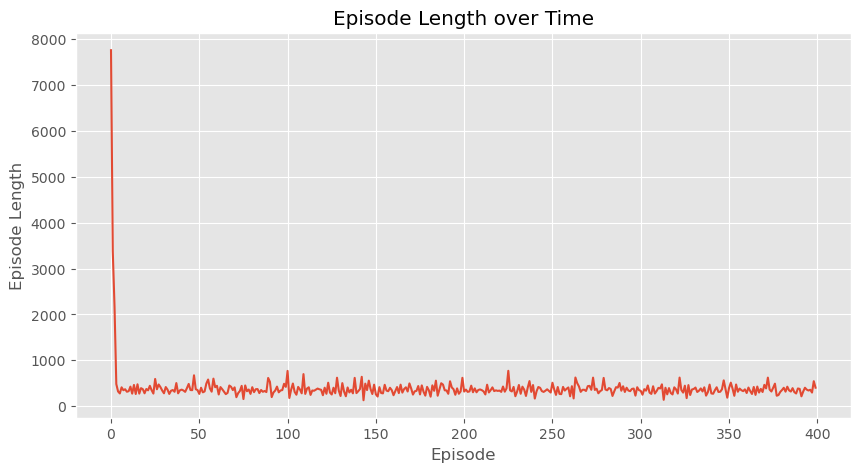

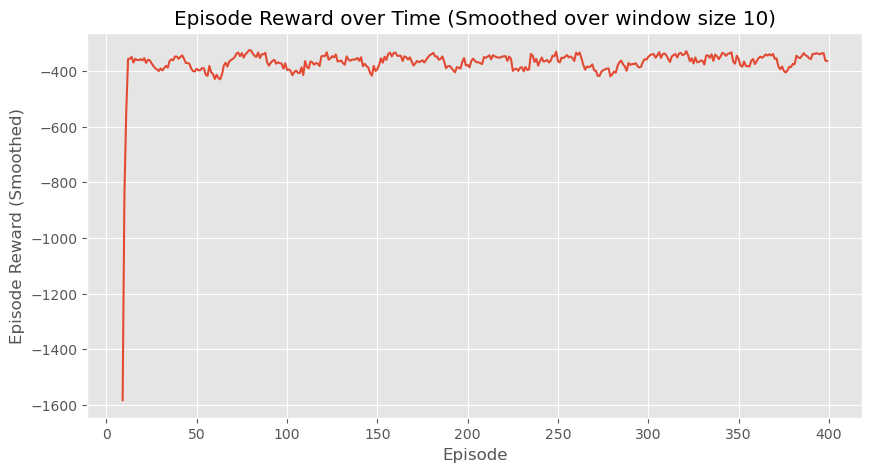

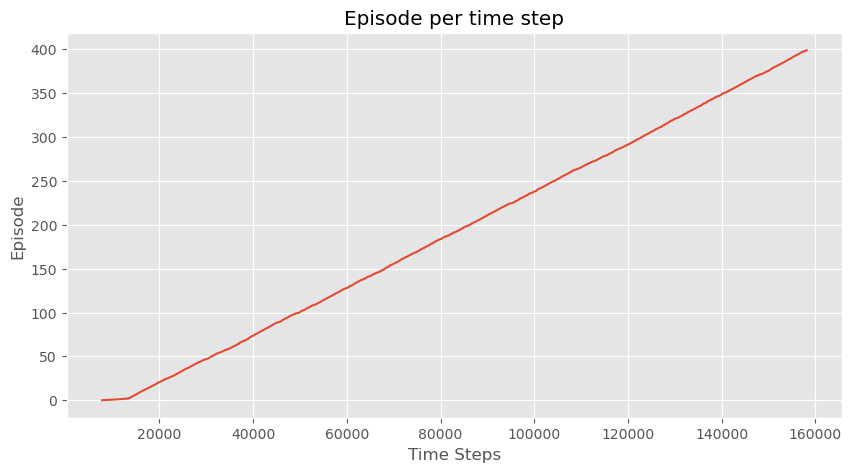

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [16]:
plots.plot_episode_stats(stats)